In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ctgan import CTGAN
from ctgan import load_demo
import pandas as pd
from table_evaluator import TableEvaluator
import os
import argparse
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from rdt import HyperTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
import pickle

In [3]:
# load data
df_real = pd.read_csv('../data/aline_data.csv')
# drop the first three columns
df_real = df_real.drop(['subject_id', 'hadm_id', 'icustay_id'],axis=1)
# transform categorical data into numbers using rdt
ht = HyperTransformer()
ht.detect_initial_config(data=df_real)
ht.fit(df_real)
transformed_data = ht.transform(df_real)
# drop NAN rows
transformed_data = transformed_data.dropna()
transformed_data = transformed_data.reset_index(drop=True)

# standardize the data to [-1, 1]
mind = transformed_data.min(axis=0)
standard_real = transformed_data-mind
maxd = standard_real.max(axis=0)
standard_real = standard_real*2/maxd -1
standard_real = standard_real.fillna(0)

# split the data into training, validating, testing sets
df_std = pd.DataFrame(standard_real)
train, test = train_test_split(standard_real, test_size=0.2)
validation, test = train_test_split(test, test_size=0.5)
train.to_csv('../data/train.csv')
test.to_csv('../data/test.csv')

In [21]:
# train a model to predict alien_flag using original data
X_train = train.drop('aline_flag', axis=1)
y_train = train['aline_flag']
X_test = test.drop('aline_flag', axis=1)
y_test = test['aline_flag']
model = MLPClassifier(hidden_layer_sizes=(64,32,16), max_iter=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate the test dataset
accuracy = accuracy_score(y_test, y_pred)
f1_org = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'f1 score: {f1_org}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.8142292490118577
f1 score: 0.8049792531120332
Confusion Matrix:
[[109  21]
 [ 26  97]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.81      0.84      0.82       130
         1.0       0.82      0.79      0.80       123

    accuracy                           0.81       253
   macro avg       0.81      0.81      0.81       253
weighted avg       0.81      0.81      0.81       253



C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
# save this model
with open("../model/model1.pkl", "wb") as f:
	pickle.dump(model, f)

In [35]:
# define parameters

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of second order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=48, help="dimensionality of the latent space")
parser.add_argument("--attr_size", type=int, default=51, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen data samples")
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epochs=200, batch_size=128, lr=0.002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=48, attr_size=51, channels=1, sample_interval=400)


In [36]:
# train a simple encoder-decoder model to augment data
data_in = Input(shape=(opt.attr_size,))
encoded = Dense(opt.latent_dim, activation='tanh')(data_in)
decoded = Dense(opt.attr_size, activation='tanh')(encoded)
autoencoder = Model(data_in, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(train, train, epochs=100, batch_size=64, validation_data=(validation, validation))
encoder_model = Model(data_in, encoded)

Epoch 1/100
32/32 [==============================] - 1s 7ms/step - loss: 0.4965 - val_loss: 0.2948
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2291 - val_loss: 0.2017
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.1774 - val_loss: 0.1619
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1439 - val_loss: 0.1320
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1188 - val_loss: 0.1102
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0997 - val_loss: 0.0937
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0849 - val_loss: 0.0809
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0709
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0626
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0557
Epoch 11/

In [37]:
# define generator
data_shape = (opt.channels, opt.attr_size)

generator = Sequential()
generator.add(Dense(64, input_dim=opt.latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization(momentum=0.8))
# generator.add(Dense(128, input_dim=opt.latent_dim))
# generator.add(LeakyReLU(0.2))
# generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(opt.attr_size, activation='tanh'))

adam = Adam(lr=opt.lr, beta_1=opt.b1)
generator.compile(loss='binary_crossentropy', optimizer=adam)

# define discriminator
discriminator = Sequential()
discriminator.add(Dense(128, input_dim=opt.attr_size))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(64, input_dim=opt.attr_size))
discriminator.add(LeakyReLU(0.2))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# define GAN model
discriminator.trainable = False
ganInput = Input(shape=(opt.latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

c:\Users\lenovo\anaconda3.1\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [38]:
batchCount = train.shape[0]//opt.batch_size
dloss = []
gloss = []
ep = []
# train the GAN model
for e in range(1, opt.n_epochs+1):
    # print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(batchCount)):
        # noise = np.random.normal(0, 1, size=[opt.batch_size, opt.latent_dim])
        dataBatch = train.iloc[np.random.randint(0, train.shape[0], size=opt.batch_size)]
        # dataBatch2 = train.iloc[np.random.randint(0, train.shape[0], size=opt.batch_size)]
        noise_encoder2 = encoder_model.predict(dataBatch)
        generatedData = generator.predict(noise_encoder2)
        d = np.concatenate([dataBatch, generatedData])
        
        yDis = np.zeros(2*opt.batch_size)
        yDis[:opt.batch_size]=0.9
        labelNoise = np.random.random(yDis.shape)
        yDis += 0.05*labelNoise + 0.05
        
        discriminator.trainable=True
        d_loss = discriminator.train_on_batch(d, yDis)
        # noise = np.random.normal(0, 1, size=[opt.batch_size, opt.latent_dim])
        dataBatch3 = train.iloc[np.random.randint(0, train.shape[0], size=opt.batch_size)]
        noise_encoder3 = encoder_model.predict(dataBatch3)
        yGen = np.ones(opt.batch_size)
        discriminator.trainable=False
        g_loss = gan.train_on_batch(noise_encoder3, yGen)
    dloss.append(d_loss)
    gloss.append(g_loss)
    ep.append(e)

100%|██████████| 15/15 [00:02<00:00,  6.77it/s]


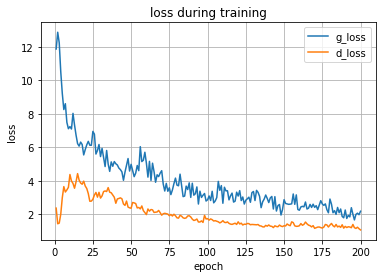

In [39]:
# plot the D loss and G loss
plt.figure()
plt.title('loss during training')
plt.plot(ep, gloss, label='g_loss')
plt.plot(ep, dloss, label='d_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# save the model and loss data
# generator.save('../model/GAN-autoencoder')
model_architecture = generator.to_json()
with open("../model/mimic-generator1.pkl", "wb") as f:
	pickle.dump(model_architecture, f)
# Save the trained weights
model_weights = generator.get_weights()
with open('../model/mimic-model-weights1.pkl', 'wb') as f:
    pickle.dump(model_weights, f)
# generator = keras.models.load_model('model/GAN-noise')
loss = np.zeros((len(ep), 3))
loss[:,0]=ep
loss[:,1]=dloss
loss[:,2]=gloss
df_loss = pd.DataFrame(data=loss, columns=['epoch', 'd_loss', 'g_loss'])
df_loss.to_csv('../result/mimic-gan-loss.csv')

In [40]:
# generate new data
# data_sample = train.iloc[np.random.randint(0, train.shape[0], size=1000)]
data_sample = train
noise_encoder = encoder_model.predict(data_sample)
generatedData = generator.predict(noise_encoder)
df_synGAN = pd.DataFrame(generatedData, columns=list(test.columns))
df_syn = df_synGAN
df_synGAN += 1
df_synGAN = df_synGAN*maxd/2
df_synGAN += mind
original_format_data = ht.reverse_transform(df_synGAN)
original_format_data.to_csv('../result/mimic-gan-synthesis.csv')
print(original_format_data)

            age gender       icustay_intime day_icu_intime  hour_icu_intime  \
0     90.211828      F  2101-09-10 21:50:00        Tuesday               14   
1     45.948433      M  2175-10-06 11:00:00      Wednesday               13   
2     17.010754      M  2172-07-30 19:20:00         Friday               17   
3     59.378419      F  2168-11-04 13:43:00         Sunday               15   
4     22.952871      M  2168-06-16 01:47:00      Wednesday               19   
...         ...    ...                  ...            ...              ...   
2013  50.603745      F  2188-06-30 19:05:00       Saturday                6   
2014  46.452360      F  2117-12-17 19:00:00       Saturday               13   
2015  54.356841      F  2153-04-30 23:30:00      Wednesday               18   
2016  51.376083      M  2192-03-24 07:00:00      Wednesday               16   
2017  23.831603      M  2120-03-25 17:30:00      Wednesday               22   

      icu_hour_flag      icustay_outtime  icu_los_d

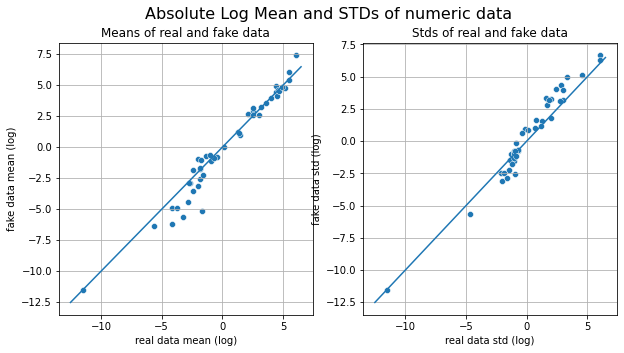

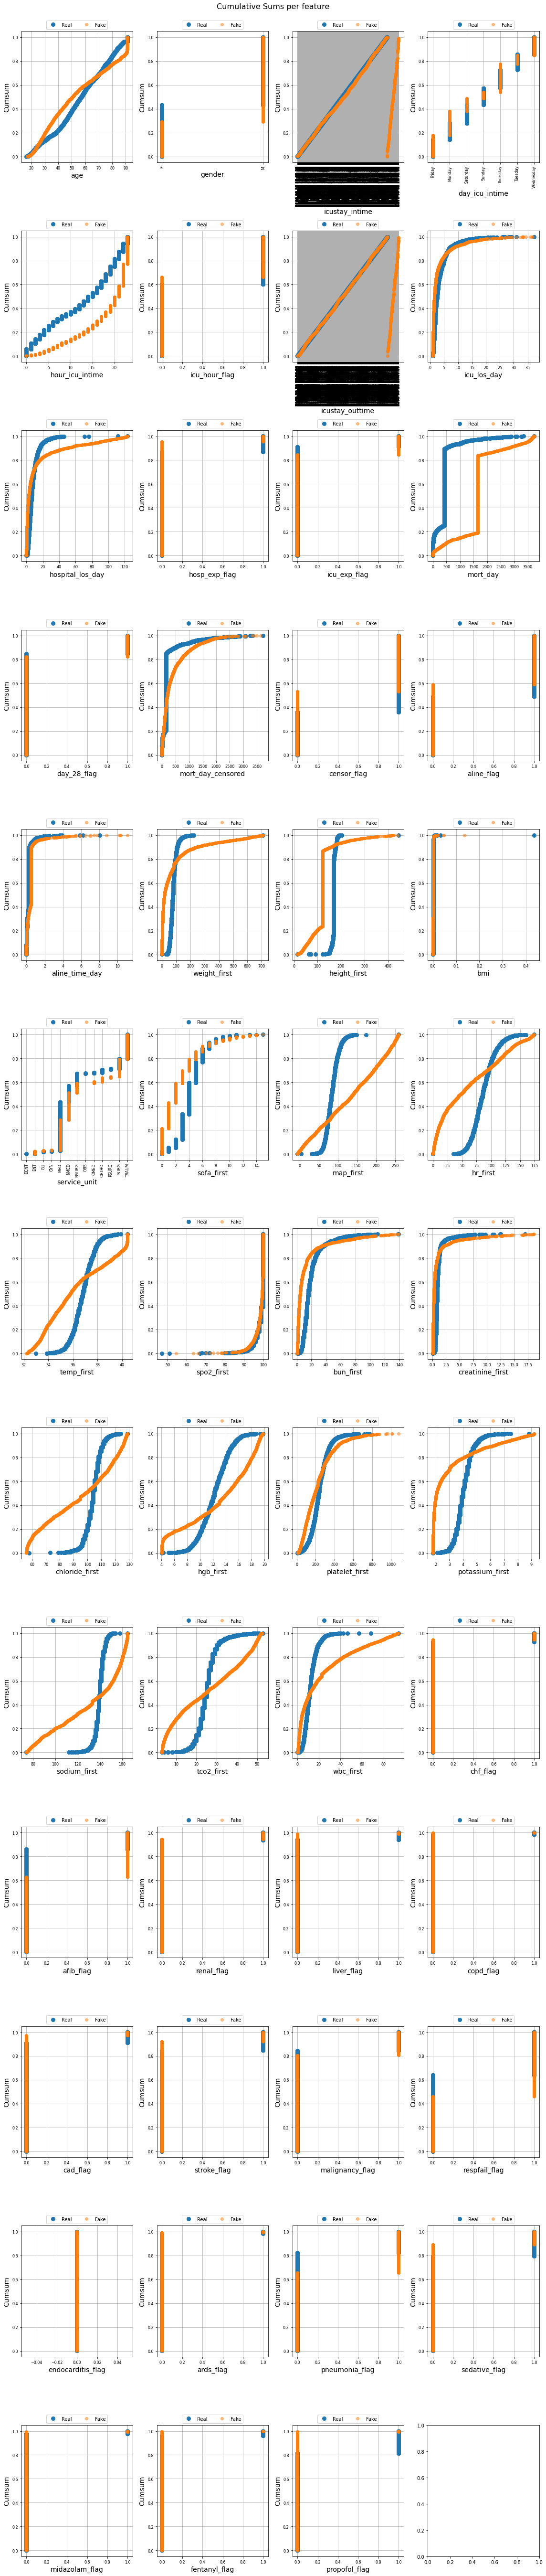

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\

LinAlgError: singular matrix

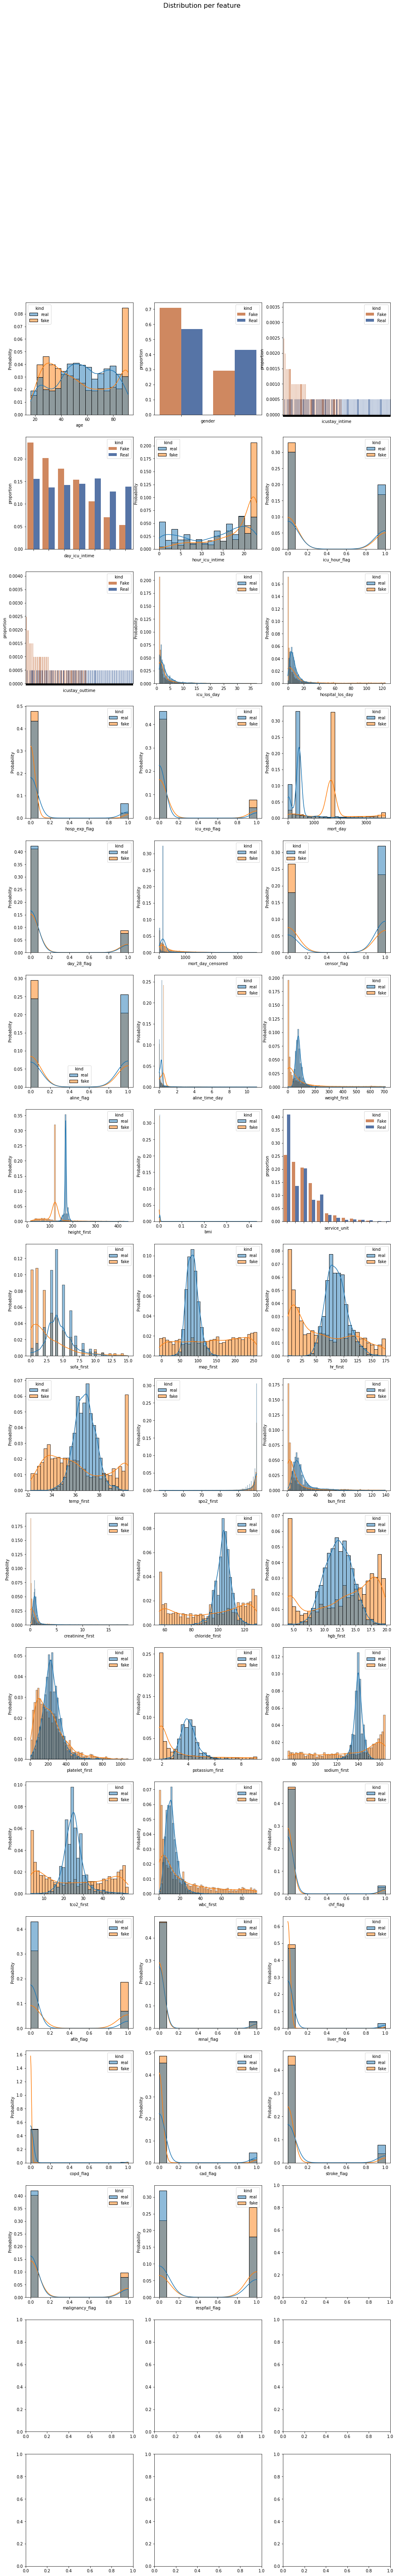

In [13]:
table_evaluator = TableEvaluator(df_real, original_format_data)
table_evaluator.visual_evaluation()

In [11]:
# from scipy.spatial.distance import euclidean
# distances = 0
# rows = train.shape[0]
# for i in range(rows):
#     distance = euclidean(train.iloc[i], df_syn.iloc[i])
#     distances+=distance
# evg_distance = distances/train.shape[0]
# print(evg_distance)

8.988680803906218


In [42]:
# used both train and generated data as training data for the model

# df_syn = pd.read_csv('../result/mimic-gan-synthesis.csv')
# df_syn = df_syn.drop('Unnamed: 0', axis=1)
gen_x = df_syn.drop('aline_flag', axis=1)
gen_y = df_syn['aline_flag']
round_y = gen_y.apply(lambda x: -1 if x<0 else 1)
nx = np.append(X_train.values, values = gen_x.values, axis=0)
new_x = pd.DataFrame(nx, columns=list(gen_x.columns))
ny = np.append(y_train.values, values = round_y.values, axis=0)
new_y = pd.DataFrame(ny)
model2 = MLPClassifier(hidden_layer_sizes=(64,32,16), max_iter=50, random_state=42)
model2.fit(new_x, new_y)
# model = DecisionTreeClassifier(random_state=42)
# model.fit(X_train, y_train)
y_pred = model2.predict(X_test)

# evaluate the test dataset
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7707509881422925
Confusion Matrix:
[[ 92  38]
 [ 20 103]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.82      0.71      0.76       130
         1.0       0.73      0.84      0.78       123

    accuracy                           0.77       253
   macro avg       0.78      0.77      0.77       253
weighted avg       0.78      0.77      0.77       253



C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
f1_all = []
rows_syn = []
for i in range(0,2100,100):
    x = gen_x.iloc[0:i]
    y = round_y.iloc[0:i]
    nx = np.append(X_train.values, values = x.values, axis=0)
    new_x = pd.DataFrame(nx, columns=list(gen_x.columns))
    ny = np.append(y_train.values, values = y.values, axis=0)
    new_y = pd.DataFrame(ny)
    model2 = MLPClassifier(hidden_layer_sizes=(64,32,16), max_iter=50, random_state=42)
    model2.fit(new_x, new_y)
    y_pred = model2.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_all.append(f1)
    rows_syn.append(i)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: St

In [44]:
f1_data = np.zeros((len(f1_all), 2))
f1_data[:,0]=rows_syn
f1_data[:,1]=f1_all
df_f1 = pd.DataFrame(data=f1_data, columns=['number of rows', 'f1_score'])
df_f1.to_csv('../result/mimic-gan-f1-score1.csv')

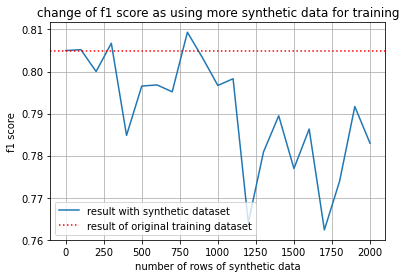

In [45]:
plt.figure()
plt.title('change of f1 score as using more synthetic data for training')
plt.plot(rows_syn, f1_all, label='result with synthetic dataset')
plt.axhline(xmin=0,xmax=2000,y=f1_org, color='r', label='result of original training dataset', linestyle=":")
plt.xlabel('number of rows of synthetic data')
plt.ylabel('f1 score')
plt.legend()
plt.grid()
plt.savefig('../images/f1-score1.png')
plt.show()

### Use Copulas to augment data

In [26]:
# try to use copulas library to generate data
import copulas
from copulas.multivariate import GaussianMultivariate

In [27]:
copula = GaussianMultivariate()
copula.fit(train)
synthetic_data = copula.sample(len(train))
synthetic_data

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_continuous_distns.py:4965: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_continuous_distns.py:4956: RuntimeWarning: divide by zero encountered in power
  return c

,age,gender,icustay_intime,day_icu_intime,hour_icu_intime,icu_hour_flag,icustay_outtime,icu_los_day,hospital_los_day,hosp_exp_flag,...,stroke_flag,malignancy_flag,respfail_flag,endocarditis_flag,ards_flag,pneumonia_flag,sedative_flag,midazolam_flag,fentanyl_flag,propofol_flag
0,0.749527,-0.794822,0.059574,0.151712,0.034541,-0.838095,-0.057493,-0.932287,-0.923224,-1.046175,...,-0.916664,-0.877160,-1.036813,0.0,-0.944123,-1.120030,-0.818473,-0.990432,-0.956707,-0.890736
1,0.620998,0.619950,-0.205548,-0.335840,0.687658,-1.197769,-0.222130,-0.958850,-0.980716,0.762713,...,-0.917740,-1.011297,0.974461,0.0,-0.936452,-1.259751,-1.187818,-1.051915,-1.085838,-1.161078
2,-0.907708,0.084647,-0.964581,0.688567,0.618442,-0.709794,-0.948403,-0.999153,-0.990706,-0.944508,...,-0.999458,-1.244147,-0.592884,0.0,-0.966537,0.890513,-0.904758,-0.998107,-0.950208,-0.906757
3,-0.024033,-0.273061,0.959100,-0.146933,0.716787,-1.127737,0.953066,-0.957294,-0.761350,-1.328543,...,-1.063543,-1.147141,-0.763439,0.0,-1.028118,-0.816948,0.819428,-1.023538,-1.007305,-0.691056
4,0.860856,0.145817,-0.792878,-0.865099,-0.461302,-0.819103,-0.825117,-0.901339,-0.771781,-0.880962,...,-0.937828,-1.099351,1.020254,0.0,-0.989129,-0.780931,-1.143944,-0.910369,-0.996946,-1.178822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,0.382445,0.569307,-0.707163,0.233583,-0.493505,-0.578127,-0.669022,-0.792627,-0.845057,-0.738727,...,1.098334,0.961434,0.869853,0.0,-0.963560,0.886814,-1.202525,-1.057301,-1.087971,-1.161397
2014,-0.209779,-0.356473,0.221396,-0.628790,-0.344407,-1.361656,0.242339,0.502180,-0.845776,-1.049949,...,-0.863754,-1.163884,1.161390,0.0,-0.918497,0.907651,-0.826348,-0.823944,-0.912694,-0.924439
2015,1.294790,-0.805853,-0.914757,0.908931,-0.440672,1.278131,-0.921281,-0.983348,-0.926391,0.751168,...,-0.614282,-0.913282,-1.133420,0.0,-0.944259,-1.080195,-1.257879,-1.016411,-1.089990,-1.203319
2016,0.362732,0.701573,0.938740,-0.530267,0.821445,-0.948293,0.946639,-0.944172,-0.900232,-0.898774,...,0.849997,-0.965131,-1.083338,0.0,-0.991823,0.731656,-1.063833,-0.960084,-1.124576,-1.028273


In [28]:
df_org = pd.DataFrame(synthetic_data, columns=list(test.columns))
df_o = df_org
df_org += 1
df_org = df_org*maxd/2
df_org += mind
original_copulas_data = ht.reverse_transform(df_org)

In [29]:
# used both train and generated data as training data for the model
gen_x2 = df_o.drop('aline_flag', axis=1)
gen_y2 = df_o['aline_flag']
round_y2 = gen_y2.apply(lambda x: -1 if x<0 else 1)

In [30]:
f1_all2 = []
rows_syn2 = []
for i in range(0,2100,100):
    x = gen_x2.iloc[0:i]
    y = round_y2.iloc[0:i]
    nx = np.append(X_train.values, values = x.values, axis=0)
    new_x = pd.DataFrame(nx, columns=list(gen_x2.columns))
    ny = np.append(y_train.values, values = y.values, axis=0)
    new_y = pd.DataFrame(ny)
    model2 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=42)
    model2.fit(new_x, new_y)
    y_pred = model2.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_all2.append(f1)
    rows_syn2.append(i)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: S

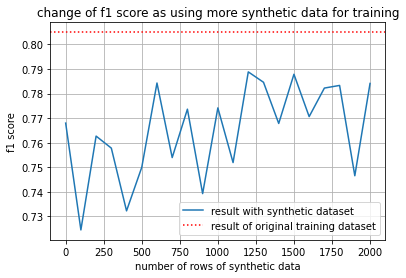

In [33]:
f1_data = np.zeros((len(f1_all2), 2))
f1_data[:,0]=rows_syn2
f1_data[:,1]=f1_all2
df_f1 = pd.DataFrame(data=f1_data, columns=['number of rows', 'f1_score'])

plt.figure()
plt.title('change of f1 score as using more synthetic data for training')
plt.plot(rows_syn2, f1_all2, label='result with synthetic dataset')
plt.axhline(xmin=0,xmax=2000,y=f1_org, color='r', label='result of original training dataset', linestyle=":")
plt.xlabel('number of rows of synthetic data')
plt.ylabel('f1 score')
plt.legend()
plt.grid()
plt.show()

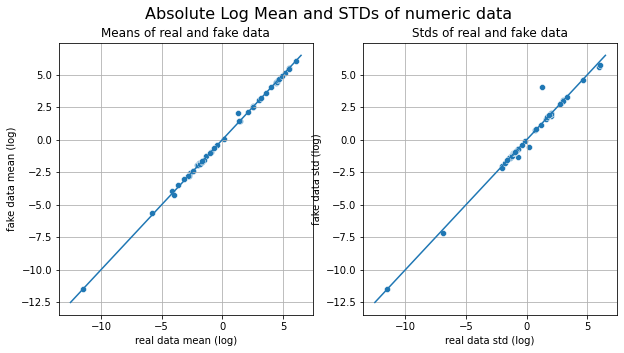

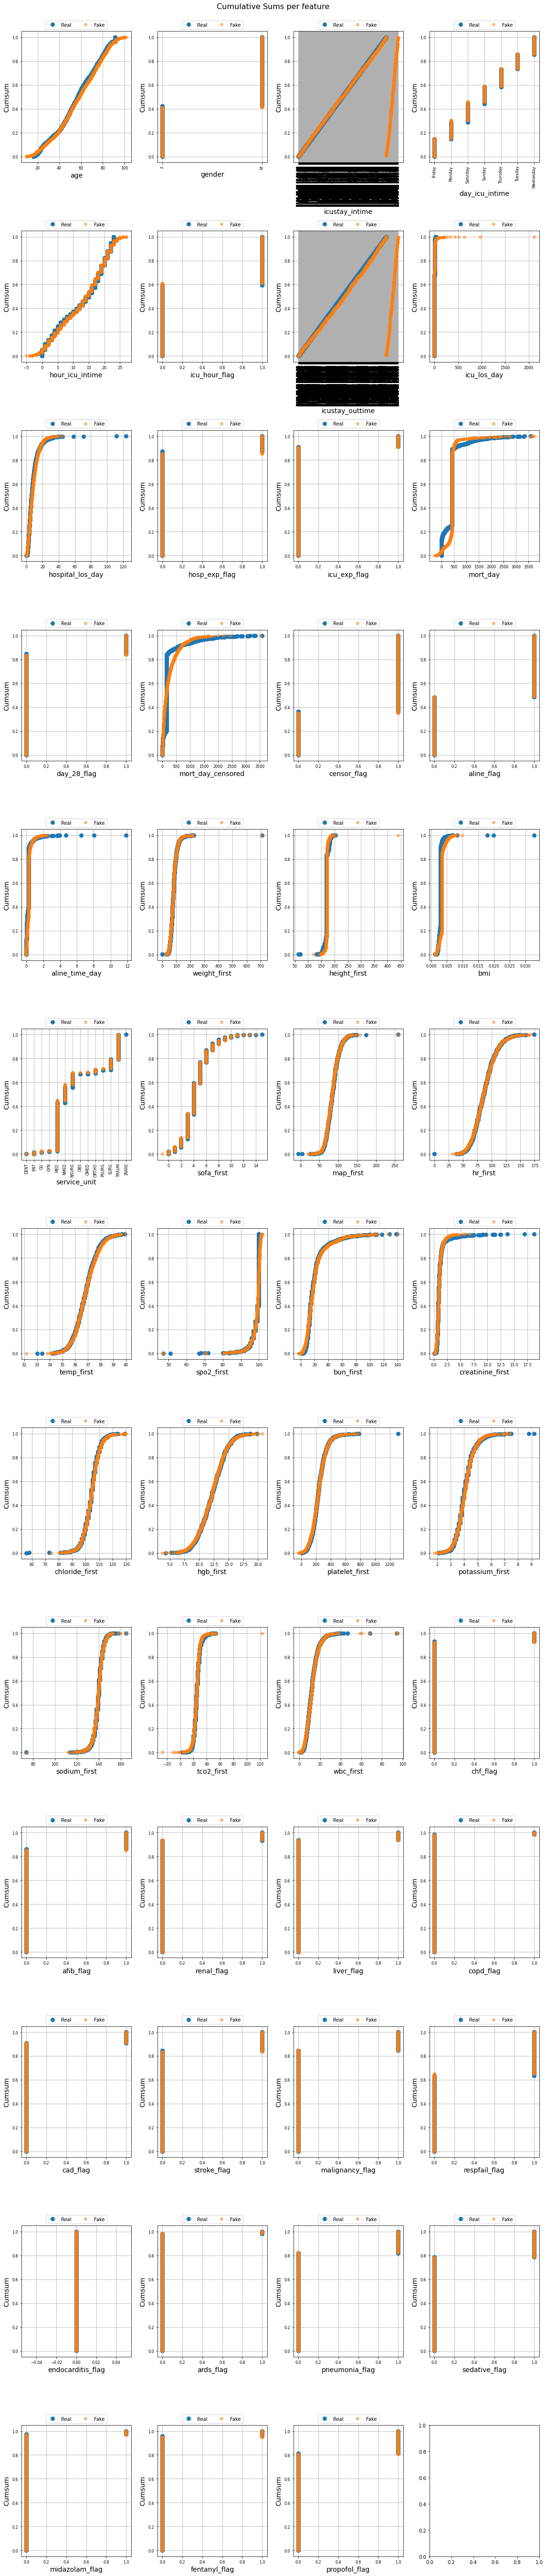

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\

LinAlgError: singular matrix

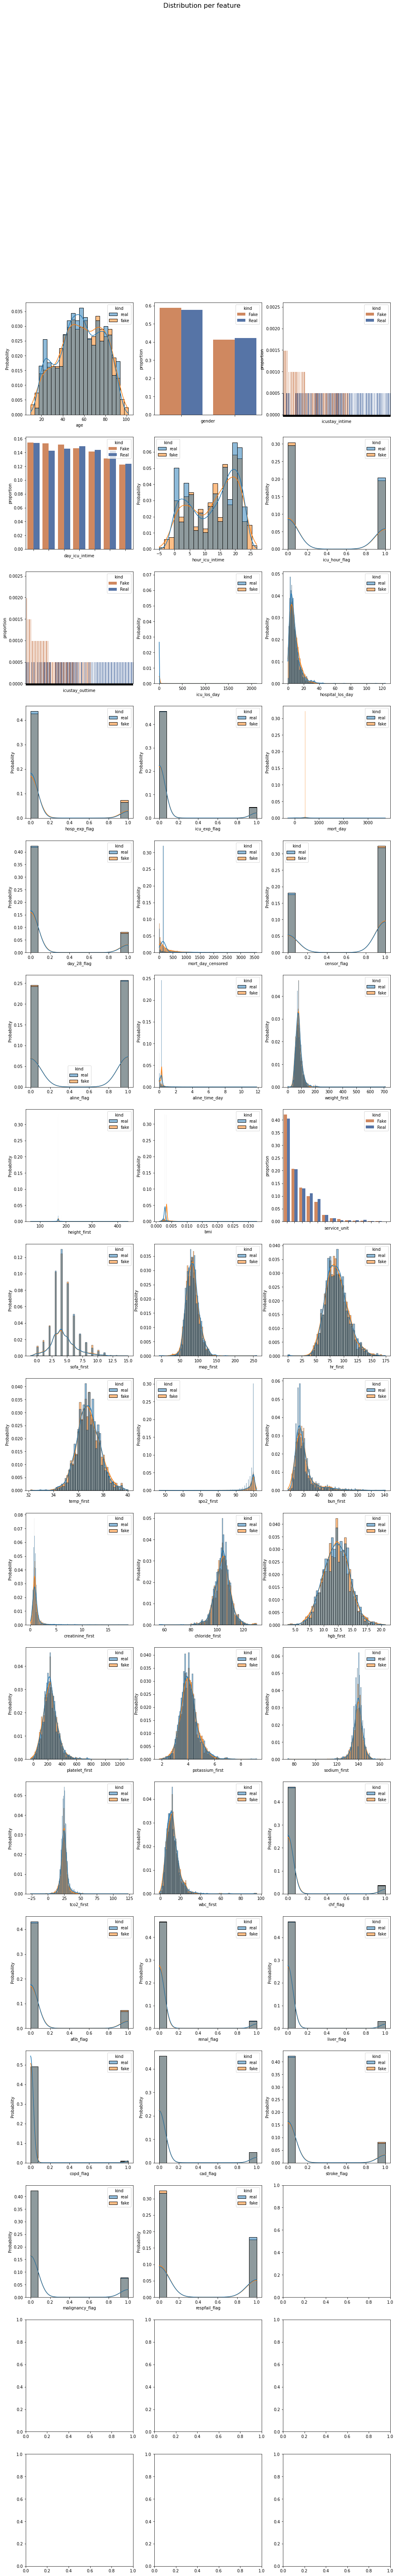

In [25]:
table_evaluator = TableEvaluator(df_real, original_copulas_data)
table_evaluator.visual_evaluation()

### Use CTGAN to augment data

In [13]:
# use CTGAN to augment data
discrete_columns = ['gender', 'day_icu_intime', 'hosp_exp_flag', 'icu_exp_flag', 'day_28_flag',
 'censor_flag', 'aline_flag', 'service_unit', 'sofa_first', 'chf_flag', 'afib_flag',
 'renal_flag', 'liver_flag', 'copd_flag', 'cad_flag', 'stroke_flag', 'malignancy_flag',
 'respfail_flag', 'endocarditis_flag', 'ards_flag', 'pneumonia_flag', 'sedative_flag',
 'midazolam_flag', 'fentanyl_flag', 'propofol_flag']

In [14]:
# training
ctgan = CTGAN(epochs=10)
ctgan.fit(train, discrete_columns)

In [16]:
samples = ctgan.sample(2000)
# df_samples = pd.DataFrame(synthetic_data, columns=list(test.columns))
df_s = samples
df_s += 1
df_s = df_s*maxd/2
df_s += mind
original_ctgan_data = ht.reverse_transform(df_s)

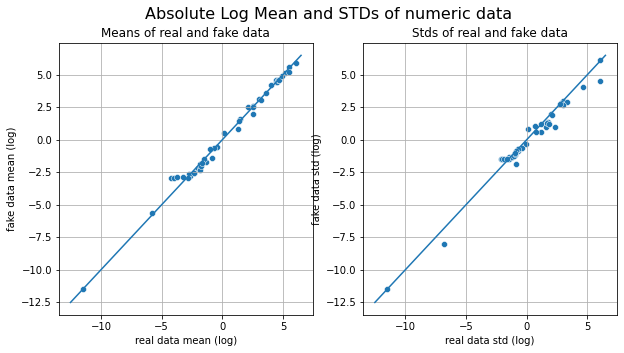

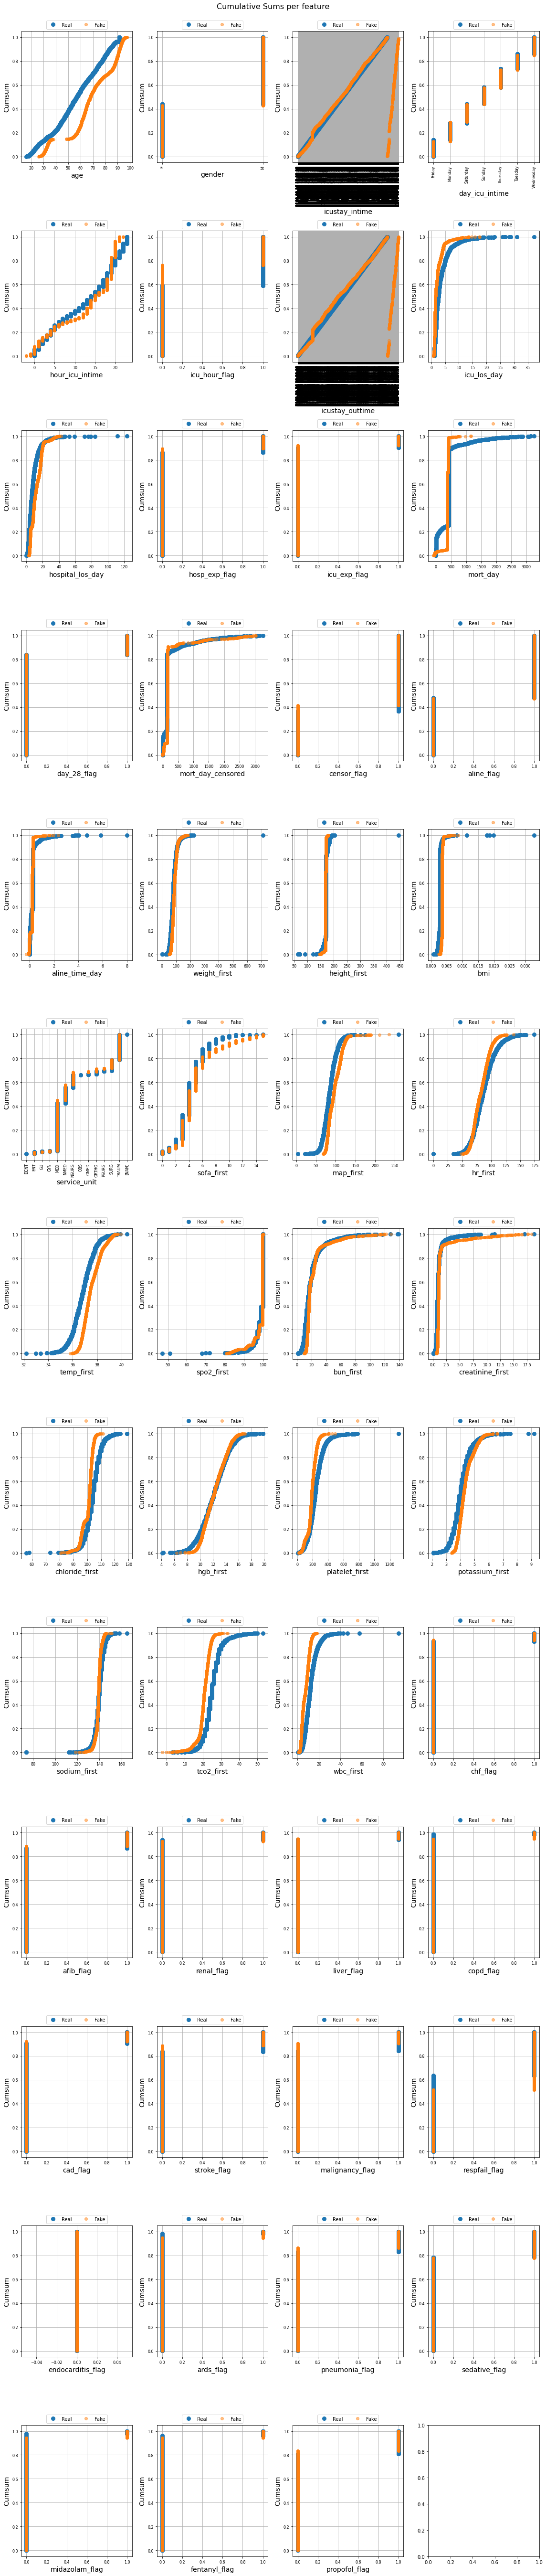

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\

LinAlgError: singular matrix

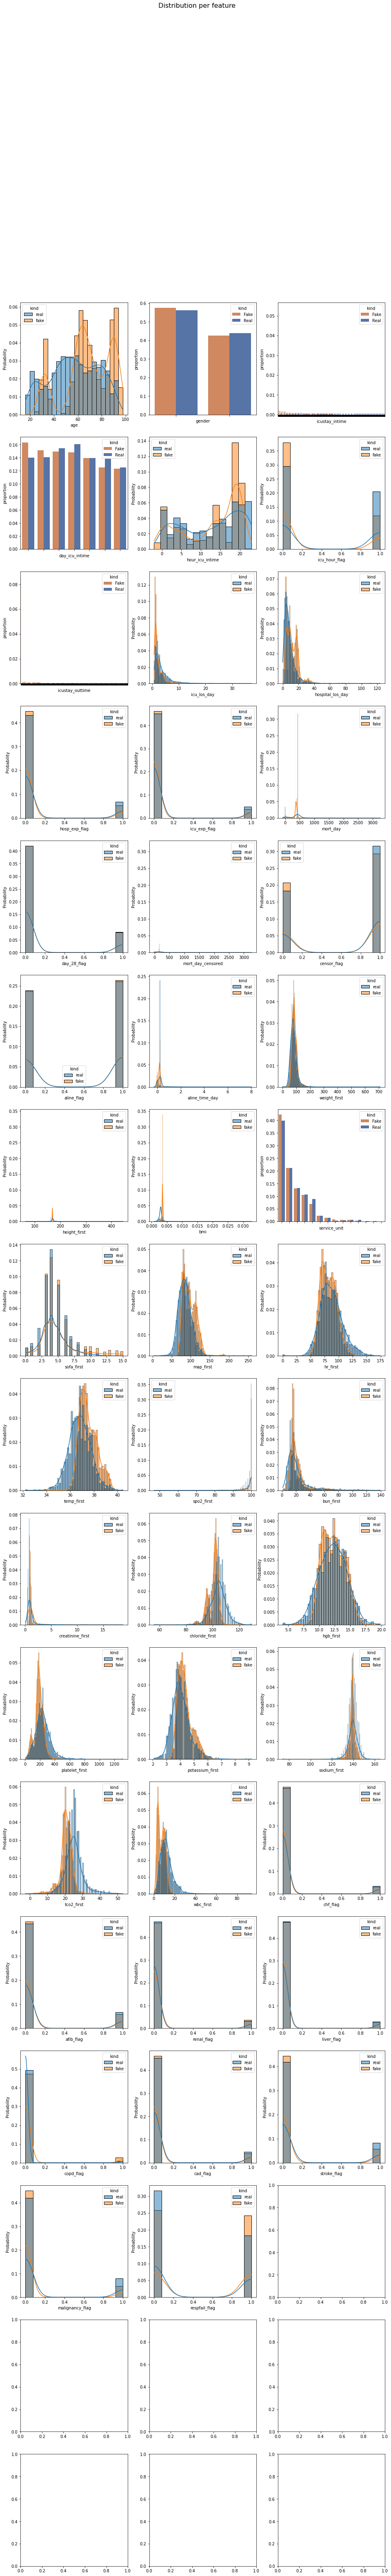

In [17]:
table_evaluator = TableEvaluator(df_real, original_ctgan_data)
table_evaluator.visual_evaluation()

In [18]:
# used both train and generated data as training data for the model
gen_x3 = df_s.drop('aline_flag', axis=1)
gen_y3 = df_s['aline_flag']
round_y3 = gen_y3.apply(lambda x: -1 if x<0 else 1)

In [23]:
f1_all3 = []
rows_syn3 = []
for i in range(0,2100,100):
    x = gen_x3.iloc[0:i]
    y = round_y3.iloc[0:i]
    nx = np.append(X_train.values, values = x.values, axis=0)
    new_x = pd.DataFrame(nx, columns=list(gen_x3.columns))
    ny = np.append(y_train.values, values = y.values, axis=0)
    new_y = pd.DataFrame(ny)
    model3 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=42)
    model3.fit(new_x, new_y)
    y_pred = model3.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_all3.append(f1)
    rows_syn3.append(i)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: S

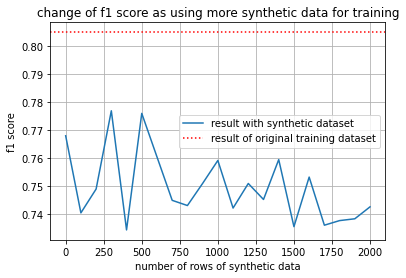

In [31]:
f1_data = np.zeros((len(f1_all3), 2))
f1_data[:,0]=rows_syn3
f1_data[:,1]=f1_all3
df_f1 = pd.DataFrame(data=f1_data, columns=['number of rows', 'f1_score'])

plt.figure()
plt.title('change of f1 score as using more synthetic data for training')
plt.plot(rows_syn3, f1_all3, label='result with synthetic dataset')
plt.axhline(xmin=0,xmax=2000,y=f1_org, color='r', label='result of original training dataset', linestyle=":")
plt.xlabel('number of rows of synthetic data')
plt.ylabel('f1 score')
plt.legend()
plt.grid()
plt.show()